In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score)

from itertools import combinations

# Ignore all warnings
warnings.filterwarnings("ignore")

In [45]:
# Define a manual mapping of genres to colors (from your reference plot)
fixed_genre_colors = {
    "Pop": "#1F77B4",  # Blue
    "Hip Hop": "#AEC7E8",  # Orange
    "Electronic": "#FF7F0E",  # Green
    "R&B": "#FFBB78",  # Red
    "Rock": "#2CA02C",  # Purple
    "Folk/Acoustic": "#98DF8A",  # Brown
    "Metal": "#D62728",  # Pink
    "World/Traditional": "#FF9896",  # Gray
    "Easy listening": "#9467BD",  # Yellow-green
    "Jazz": "#C5B0D5",  # Cyan
    "Latin": "#8C564B",  # Light Blue
    "Country": "#C49C94",  # Light Orange
    "Blues": "#E377C2",  # Light Green
    "Classical": "#FDE9F1",  # Light Red
    "New age": "#BFBFBF"  # Light Purple
}

In [ ]:
SAF = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo"]

def process_audio_embeddings(folder_path, playlist_path):
    # Load playlist CSV
    playlist_df = pd.read_csv(playlist_path)
    
    # Extract unique Track IDs from the playlist
    track_id_counts = playlist_df['Track ID'].value_counts()

    # List to store data
    data = []

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npz'):
            # Extract Track ID (first 22 characters of file name)
            track_id = file_name[:22]
            
            # Load the .npz file
            file_path = os.path.join(folder_path, file_name)
            with np.load(file_path) as npz_file:
                # Assuming embeddings are stored in a key named 'embeddings' in the .npz file
                embeddings = npz_file['embeddings']
            
            # Get the duplication count for the current Track ID
            duplication_count = track_id_counts.get(track_id, 0)
            
            # Append data (duplicate as needed)
            for _ in range(duplication_count):
                data.append([track_id] + embeddings.flatten().tolist())

    # Create DataFrame
    column_names = ['Track ID'] + [f'embedding_{i}' for i in range(len(data[0]) - 1)]
    return pd.DataFrame(data, columns=column_names)

def merge_genres_with_embeddings(genres_df, embeddings_df):
    # Deduplicate embeddings DataFrame to ensure one row per Track ID
    embeddings_df_unique = embeddings_df.drop_duplicates(subset=['Track ID'], keep='first')
    
    # Perform the left merge
    merged_df = pd.merge(genres_df, embeddings_df_unique, on='Track ID', how='left')
    
    # Validate row count matches genres_df
    if merged_df.shape[0] != genres_df.shape[0]:
        raise ValueError(f"Row count mismatch: {merged_df.shape[0]} rows in merged DataFrame, expected {genres_df.shape[0]}.")
    
    return merged_df

def merge_genres_with_SAF(genres_df, SAF_df):
    # Deduplicate embeddings DataFrame to ensure one row per Track ID
    SAF_df_unique = SAF_df.drop_duplicates(subset=['Track ID'], keep='first')
    
    # Perform the left merge
    merged_df = pd.merge(genres_df, SAF_df_unique, on='Track ID', how='left')
    
    # Validate row count matches genres_df
    if merged_df.shape[0] != genres_df.shape[0]:
        raise ValueError(f"Row count mismatch: {merged_df.shape[0]} rows in merged DataFrame, expected {genres_df.shape[0]}.")
    
    return merged_df

# Function to compute UMAP coordinates and merge back into the dataframe
def add_umap_coordinates_embeddings(df, n_components=2):
    # Exclude the 'reducedGenre' column for UMAP input
    feature_columns = [col for col in df.columns if col != 'reducedGenre']
    
    # Extract the feature data for UMAP
    feature_data = df[feature_columns].values

    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    # Apply UMAP to reduce dimensions
    # umap_reducer = umap.UMAP(n_components=n_components,
    #                          n_neighbors=15,
    #                          min_dist=0.1,
    #                          metric="euclidean",
    #                          random_state=42)
    
    umap_coordinates = umap_reducer.fit_transform(feature_data)

    # Create column names for the UMAP components
    umap_columns = [f'UMAP_{i+1}' for i in range(n_components)]
    umap_df = pd.DataFrame(umap_coordinates, columns=umap_columns)

    # Merge UMAP coordinates back into the original dataframe
    return pd.concat([df[['reducedGenre']].reset_index(drop=True), umap_df], axis=1)

# Function to compute UMAP coordinates and merge back into the dataframe
def add_umap_coordinates_SAF(df, n_components=2):
    # Exclude the 'reducedGenre' column for UMAP input
    feature_columns = [col for col in df.columns if col != 'reducedGenre']
    
    # Extract the feature data for UMAP
    feature_data = df[feature_columns].values

    # Standardize the feature data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_data)

    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    # Apply UMAP to reduce dimensions
    # umap_reducer = umap.UMAP(n_components=n_components,
    #                          n_neighbors=15,
    #                          min_dist=0.1,
    #                          metric="euclidean",
    #                          random_state=42)
    
    umap_coordinates = umap_reducer.fit_transform(scaled_features)

    # Create column names for the UMAP components
    umap_columns = [f'UMAP_{i+1}' for i in range(n_components)]
    umap_df = pd.DataFrame(umap_coordinates, columns=umap_columns)

    # Merge UMAP coordinates back into the original dataframe
    return pd.concat([df[['reducedGenre']].reset_index(drop=True), umap_df], axis=1)


# # Function to plot UMAP embeddings with a pre-filtered DataFrame
# def plot_embeddings(dataframes, titles, genre_column='reducedGenre', umap_columns=['UMAP_1', 'UMAP_2']):
#     # Get a sorted list of all unique genres across datasets
#     unique_genres = sorted(set(genre for df in dataframes for genre in df[genre_column].unique()))

#     # Assign a fixed color to each genre
#     palette = sns.color_palette("tab20", n_colors=len(unique_genres))
#     genre_to_color = {genre: palette[i] for i, genre in enumerate(unique_genres)}

#     for df, title in zip(dataframes, titles):
#         plt.figure(figsize=(14, 4.75)) 
        
#         # Count the number of tracks per genre and sort from most to least
#         genre_counts = df[genre_column].value_counts()
#         sorted_genres = genre_counts.index.tolist()  # Sorted genres from most to least

#         # Generate labels including count (ensuring sorted order)
#         genre_labels = {genre: f"{genre} (n = {genre_counts[genre]})" for genre in sorted_genres}

#         # Adjust color mapping to match this new sorted order in the legend
#         sorted_palette = [genre_to_color[genre] for genre in sorted_genres]
#         genre_color_mapping = {genre_labels[genre]: sorted_palette[i] for i, genre in enumerate(sorted_genres)}

#         # Scatter plot for embeddings colored by genre
#         sns.scatterplot(
#             x=umap_columns[0], 
#             y=umap_columns[1], 
#             hue=df[genre_column].map(genre_labels),  # Legend order follows genre_counts
#             palette=genre_color_mapping,  # Ensures colors stay fixed
#             data=df, 
#             legend='full', 
#             s=12
#         )
        
#         # Set title and labels
#         plt.title(title, fontsize=14)
#         plt.xlabel("UMAP component 1", fontsize=14)
#         plt.ylabel("UMAP component 2", fontsize=14)

#         # Sort legend by most to least tracks
#         handles, labels = plt.gca().get_legend_handles_labels()
#         sorted_legend = sorted(zip(handles, labels), key=lambda x: genre_counts[x[1].split(" (")[0]], reverse=True)
#         handles, labels = zip(*sorted_legend)
#         plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Genre', fontsize=10, markerscale=2)
        
#         # Show plot
#         plt.tight_layout()
#         # plt.savefig(f"/home/jellek23/MAMxAI/scripts/analysis_final/plots_final/{title}.svg", dpi=1200)
#         # plt.savefig(f"/home/jellek23/MAMxAI/scripts/analysis_final/plots_final/{title}.png", dpi=1200)
#         plt.show()

# # Function to plot UMAP embeddings with a pre-filtered DataFrame
# def plot_embeddings(dataframes, titles, genre_column='reducedGenre', umap_columns=['UMAP_1', 'UMAP_2']):
#     # Define a color palette with only two colors
#     palette = sns.color_palette("tab10", n_colors=2)

#     for df, title in zip(dataframes, titles):
#         plt.figure(figsize=(14, 4.75)) 
        
#         # Filter dataframe to only include 'Classical' and 'Metal' genres
#         filtered_df = df[df[genre_column].isin(['Classical', 'Metal'])]

#         # Count the number of tracks per genre in the filtered dataset
#         genre_counts = filtered_df[genre_column].value_counts()
#         genre_labels = {genre: f"{genre} (n = {count})" for genre, count in genre_counts.items()}

#         # Scatter plot for embeddings colored by genre
#         sns.scatterplot(
#             x=umap_columns[0], 
#             y=umap_columns[1], 
#             hue=filtered_df[genre_column].map(genre_labels),  # Update legend labels with counts
#             palette=palette, 
#             data=filtered_df, 
#             legend='full', 
#             s=12
#         )
        
#         # Set title and labels
#         plt.title(title, fontsize=14)
#         plt.xlabel("UMAP component 1", fontsize=14)
#         plt.ylabel("UMAP component 2", fontsize=14)

#         # Place legend outside the plot
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Genre', fontsize=10, markerscale=2)
        
#         # Show plot
#         plt.tight_layout()
#         plt.savefig(f"/home/jellek23/MAMxAI/scripts/analysis_final/plots_final/{title}_Classical_Metal.svg", dpi=1200)
#         plt.savefig(f"/home/jellek23/MAMxAI/scripts/analysis_final/plots_final/{title}_Classical_Metal.png", dpi=1200)
#         plt.show()

# Function to plot UMAP embeddings with a fixed genre color scheme
def plot_embeddings(dataframes, titles, genre_column='reducedGenre', umap_columns=['UMAP_1', 'UMAP_2']):
    for df, title in zip(dataframes, titles):
        plt.figure(figsize=(14, 4.75)) 
        
        # Count the number of tracks per genre and sort from most to least
        genre_counts = df[genre_column].value_counts()
        sorted_genres = genre_counts.index.tolist()  # Sorted genres from most to least

        # Generate labels including count (ensuring sorted order)
        genre_labels = {genre: f"{genre} (n = {genre_counts[genre]})" for genre in sorted_genres}

        # Adjust color mapping to match this new sorted order in the legend
        genre_color_mapping = {genre_labels[genre]: fixed_genre_colors[genre] for genre in sorted_genres if genre in fixed_genre_colors}

        # Scatter plot for embeddings colored by genre
        sns.scatterplot(
            x=umap_columns[0], 
            y=umap_columns[1], 
            hue=df[genre_column].map(genre_labels),  # Legend order follows genre_counts
            palette=genre_color_mapping,  # Ensures colors stay fixed
            data=df, 
            legend='full', 
            s=12
        )
        
        # Set title and labels
        plt.title(title, fontsize=14)
        plt.xlabel("UMAP component 1", fontsize=14)
        plt.ylabel("UMAP component 2", fontsize=14)

        # Sort legend by most to least tracks
        handles, labels = plt.gca().get_legend_handles_labels()
        sorted_legend = sorted(zip(handles, labels), key=lambda x: genre_counts[x[1].split(" (")[0]], reverse=True)
        handles, labels = zip(*sorted_legend)
        plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Genre', fontsize=10, markerscale=2)
        
        # Show plot
        plt.tight_layout()
        plt.show()

In [4]:
def evaluate_pairwise_clustering(data_saf, data_embeddings, genre_column='reducedGenre'):
    # Get unique genres
    unique_genres = data_saf[genre_column].unique()
    
    # Prepare results
    results = []
    
    # Iterate through all pairs of genres
    for genre1, genre2 in combinations(unique_genres, 2):
        # Filter data for the two genres in the pair
        saf_subset = data_saf[data_saf[genre_column].isin([genre1, genre2])]
        embedding_subset = data_embeddings[data_embeddings[genre_column].isin([genre1, genre2])]

        # Extract features and true labels
        saf_features = saf_subset.drop(columns=[genre_column]).values
        embedding_features = embedding_subset.drop(columns=[genre_column]).values
        true_labels = saf_subset[genre_column].factorize()[0]

        # Apply K-means for SAF
        kmeans_saf = KMeans(n_clusters=2, random_state=42)
        saf_cluster_labels = kmeans_saf.fit_predict(saf_features)

        # Apply K-means for embeddings
        kmeans_embeddings = KMeans(n_clusters=2, random_state=42)
        embedding_cluster_labels = kmeans_embeddings.fit_predict(embedding_features)

        # Evaluate clustering metrics
        saf_silhouette = silhouette_score(saf_features, saf_cluster_labels)
        embedding_silhouette = silhouette_score(embedding_features, embedding_cluster_labels)
        
        saf_ari = adjusted_rand_score(true_labels, saf_cluster_labels)
        embedding_ari = adjusted_rand_score(true_labels, embedding_cluster_labels)

        # Store results
        results.append({
            "Genre pair": f"{genre1} vs {genre2}",
            "SAF silhouette": saf_silhouette,
            "Embeddings silhouette": embedding_silhouette,
            "SAF ARI": saf_ari,
            "Embeddings ARI": embedding_ari,
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate summary statistics for each metric
    summary_stats = results_df.describe().loc[['mean', '50%', 'std']].rename(index={'50%': 'median'})
    summary_stats = summary_stats.reset_index().rename(columns={'index': 'Statistic'})

    return results_df, summary_stats

def evaluate_clustering_all(data_saf, data_embeddings, genre_column='reducedGenre', n_clusters=15):
    # Prepare results
    results = []

    # Extract features and true labels
    saf_features = data_saf.drop(columns=[genre_column]).values
    embedding_features = data_embeddings.drop(columns=[genre_column]).values
    true_labels = data_saf[genre_column].factorize()[0]  # Convert genres to numeric labels

    # Apply K-means for SAF
    kmeans_saf = KMeans(n_clusters=n_clusters, random_state=42)
    saf_cluster_labels = kmeans_saf.fit_predict(saf_features)

    # Apply K-means for embeddings
    kmeans_embeddings = KMeans(n_clusters=n_clusters, random_state=42)
    embedding_cluster_labels = kmeans_embeddings.fit_predict(embedding_features)

    # Evaluate clustering metrics
    saf_silhouette = silhouette_score(saf_features, saf_cluster_labels)
    embedding_silhouette = silhouette_score(embedding_features, embedding_cluster_labels)
    
    saf_ari = adjusted_rand_score(true_labels, saf_cluster_labels)
    embedding_ari = adjusted_rand_score(true_labels, embedding_cluster_labels)

    # Store results
    results.append({
        "Metric": "Silhouette",
        "SAF": saf_silhouette,
        "Embeddings": embedding_silhouette
    })
    results.append({
        "Metric": "ARI",
        "SAF": saf_ari,
        "Embeddings": embedding_ari
    })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [ ]:
# Define file paths
folder_path_EMD_SAF = ""
folder_path_PMD_SAF = ""
folder_path_EMD_embeddings = ""
folder_path_PMD_embeddings = ""
playlist_path_EMD = ""
playlist_path_PMD = ""
genres_path_EMD = ""
genres_path_PMD = ""

# Process audio embeddings
embeddings_df_EMD = process_audio_embeddings(folder_path_EMD_embeddings, playlist_path_EMD)
embeddings_df_PMD = process_audio_embeddings(folder_path_PMD_embeddings, playlist_path_PMD)

# Load genre datasets
genres_EMD = pd.read_csv(genres_path_EMD)
genres_PMD = pd.read_csv(genres_path_PMD)

# Load Spotify Audio Features
SAF_EMD = pd.read_csv(folder_path_EMD_SAF)
SAF_PMD = pd.read_csv(folder_path_PMD_SAF)

In [6]:
# Merge genres_PMD and genres_EMD with their respective embeddings
genres_embeddings_PMD = merge_genres_with_embeddings(genres_PMD, embeddings_df_PMD)
genres_embeddings_EMD = merge_genres_with_embeddings(genres_EMD, embeddings_df_EMD)

# Merge genres_PMD and genres_EMD with their respective Spotify Audio Features
genres_SAF_PMD = merge_genres_with_SAF(genres_PMD, SAF_PMD)
genres_SAF_EMD = merge_genres_with_SAF(genres_EMD, SAF_EMD)

# Keep only the embedding columns and the 'reducedGenre' column for both datasets
genres_embeddings_EMD = genres_embeddings_EMD.loc[:, ['reducedGenre'] + [col for col in genres_embeddings_EMD.columns if col.startswith('embedding_')]]
genres_embeddings_PMD = genres_embeddings_PMD.loc[:, ['reducedGenre'] + [col for col in genres_embeddings_PMD.columns if col.startswith('embedding_')]]

genres_SAF_PMD = genres_SAF_PMD.loc[:, ['reducedGenre'] + [col for col in genres_SAF_PMD.columns if col in SAF]]
genres_SAF_EMD = genres_SAF_EMD.loc[:, ['reducedGenre'] + [col for col in genres_SAF_EMD.columns if col in SAF]]

# Ensure consistent NaN dropping between EMD embeddings and SAF
# Get indices of rows with NaN values in either dataframe
nan_indices_EMD = genres_embeddings_EMD[genres_embeddings_EMD.isna().any(axis=1)].index
nan_indices_SAF_EMD = genres_SAF_EMD[genres_SAF_EMD.isna().any(axis=1)].index

# Combine NaN indices from both dataframes
combined_nan_indices_EMD = nan_indices_EMD.union(nan_indices_SAF_EMD)

# Drop the combined NaN indices from both dataframes
genres_embeddings_EMD = genres_embeddings_EMD.drop(index=combined_nan_indices_EMD).reset_index(drop=True)
genres_SAF_EMD = genres_SAF_EMD.drop(index=combined_nan_indices_EMD).reset_index(drop=True)

# Ensure consistent NaN dropping between PMD embeddings and SAF
nan_indices_PMD = genres_embeddings_PMD[genres_embeddings_PMD.isna().any(axis=1)].index
nan_indices_SAF_PMD = genres_SAF_PMD[genres_SAF_PMD.isna().any(axis=1)].index

# Combine NaN indices from both dataframes
combined_nan_indices_PMD = nan_indices_PMD.union(nan_indices_SAF_PMD)

# Drop the combined NaN indices from both dataframes
genres_embeddings_PMD = genres_embeddings_PMD.drop(index=combined_nan_indices_PMD).reset_index(drop=True)
genres_SAF_PMD = genres_SAF_PMD.drop(index=combined_nan_indices_PMD).reset_index(drop=True)

# Print the shapes to confirm alignment
print("After dropping NaNs:")
print(f"EMD Embeddings shape: {genres_embeddings_EMD.shape}")
print(f"EMD SAF shape: {genres_SAF_EMD.shape}")
print(f"PMD Embeddings shape: {genres_embeddings_PMD.shape}")
print(f"PMD SAF shape: {genres_SAF_PMD.shape}")

After dropping NaNs:
EMD Embeddings shape: (8966, 513)
EMD SAF shape: (8966, 10)
PMD Embeddings shape: (1871, 513)
PMD SAF shape: (1871, 10)


In [7]:
# Apply UMAP to both PMD and EMD dataframes
genres_embeddings_PMD_umap = add_umap_coordinates_embeddings(genres_embeddings_PMD)
genres_embeddings_EMD_umap = add_umap_coordinates_embeddings(genres_embeddings_EMD)
genres_SAF_PMD_umap = add_umap_coordinates_SAF(genres_SAF_PMD)
genres_SAF_EMD_umap = add_umap_coordinates_SAF(genres_SAF_EMD)

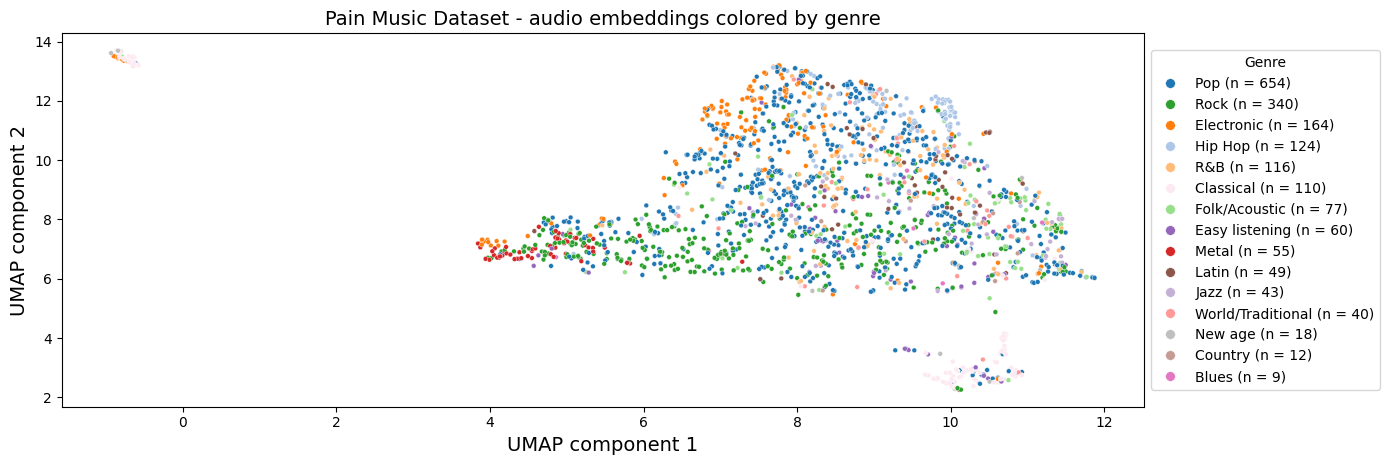

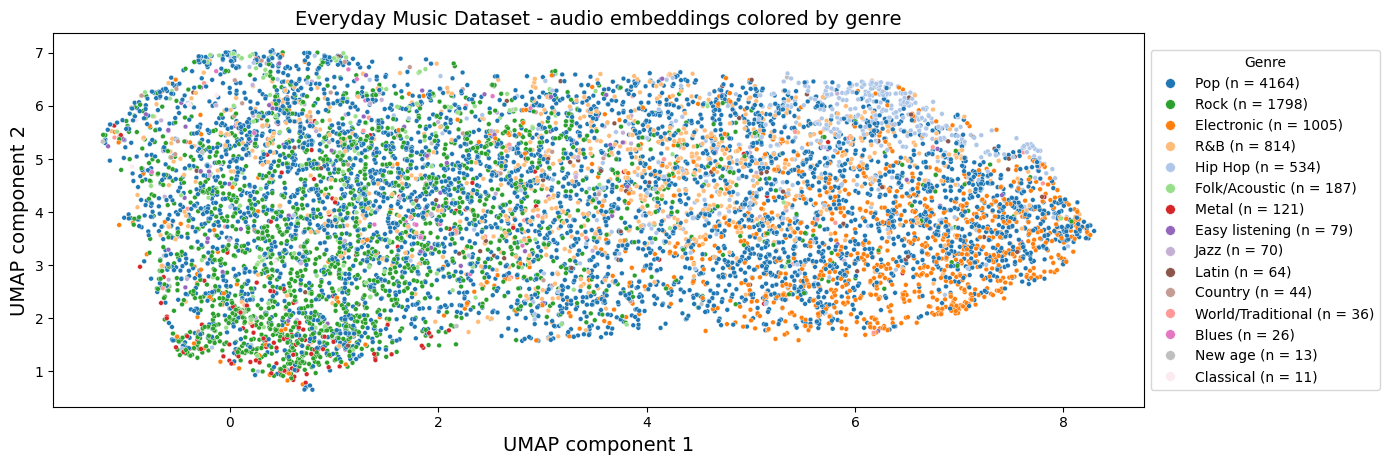

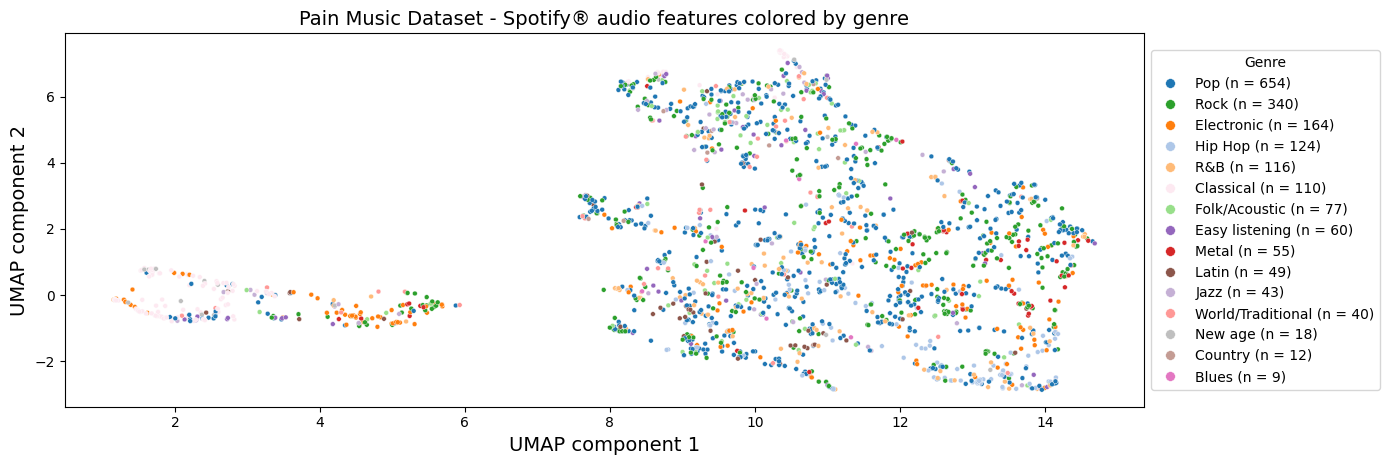

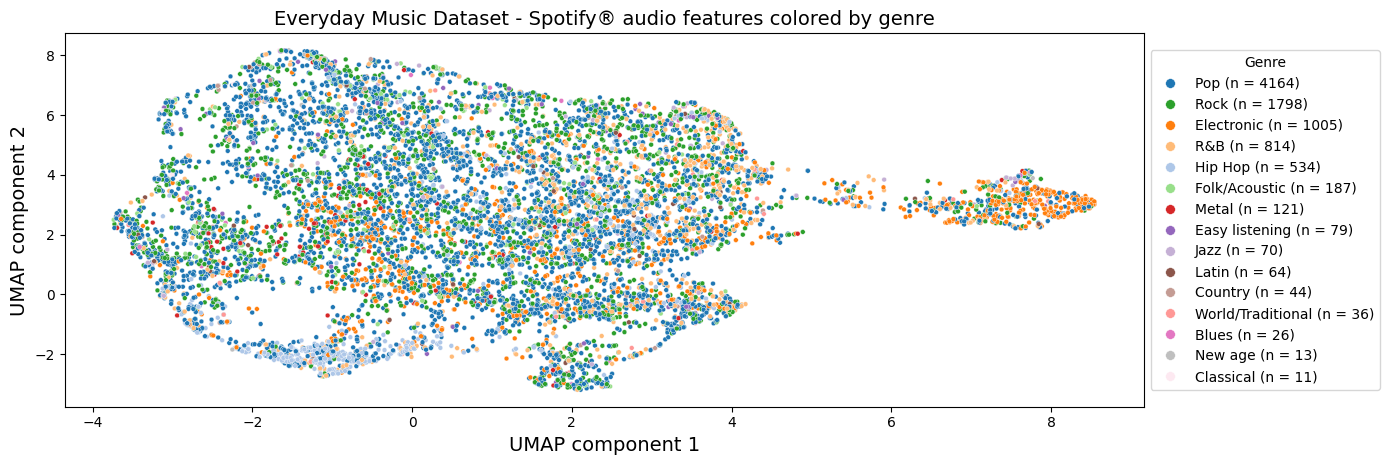

In [49]:
# Prepare dataframes and titles for visualization
dataframes = [
    genres_embeddings_PMD_umap,
    genres_embeddings_EMD_umap,
    genres_SAF_PMD_umap,
    genres_SAF_EMD_umap
]

titles = [
    "Pain Music Dataset - audio embeddings colored by genre",
    "Everyday Music Dataset - audio embeddings colored by genre",
    "Pain Music Dataset - Spotify\u00AE audio features colored by genre",
    "Everyday Music Dataset - Spotify\u00AE audio features colored by genre"
]

# Visualize the UMAP embeddings
plot_embeddings(dataframes, titles)

In [ ]:
pairwise_results_PMD, summary_stats_PMD = evaluate_pairwise_clustering(genres_SAF_PMD_umap, genres_embeddings_PMD_umap)
pairwise_results_EMD, summary_stats_EMD = evaluate_pairwise_clustering(genres_SAF_EMD_umap, genres_embeddings_EMD_umap)

# Display results for PMD and EMD
print("Pairwise clustering results for PMD:")
display(pairwise_results_PMD)

print("\nSummary statistics for PMD:")
display(summary_stats_PMD)

print("\nPairwise clustering results for EMD:")
display(pairwise_results_EMD)

print("\nSummary statistics for EMD:")
display(summary_stats_EMD)

Pairwise clustering results for PMD:


,Genre pair,SAF silhouette,Embeddings silhouette,SAF ARI,Embeddings ARI
0,Pop vs World/Traditional,0.406077,0.395282,0.026948,-0.003300
1,Pop vs Hip Hop,0.414123,0.426459,-0.031669,0.052829
2,Pop vs Rock,0.358599,0.324557,-0.000333,0.015715
3,Pop vs Latin,0.385757,0.389568,-0.022870,0.001725
4,Pop vs R&B,0.391270,0.397131,-0.005285,0.004274
...,...,...,...,...,...
100,Classical vs Country,0.837759,0.857764,0.231942,-0.094927
101,Classical vs Blues,0.828342,0.852493,0.195803,-0.082014
102,New age vs Country,0.658464,0.783918,0.190355,0.004577
103,New age vs Blues,0.654340,0.736830,0.131810,-0.048387



Summary statistics for PMD:


,Statistic,SAF silhouette,Embeddings silhouette,SAF ARI,Embeddings ARI
0,mean,0.511715,0.536563,0.095704,0.171678
1,median,0.487813,0.480100,0.034416,0.039583
2,std,0.118792,0.151558,0.157460,0.276274



Pairwise clustering results for EMD:


,Genre pair,SAF silhouette,Embeddings silhouette,SAF ARI,Embeddings ARI
0,Pop vs Hip Hop,0.365503,0.488674,0.023712,0.028640
1,Pop vs Electronic,0.336323,0.504405,0.031118,0.050560
2,Pop vs R&B,0.349747,0.464479,-0.001547,0.006021
3,Pop vs Rock,0.354082,0.476471,0.001962,0.033444
4,Pop vs Folk/Acoustic,0.350729,0.481148,-0.000034,-0.007331
...,...,...,...,...,...
100,Country vs Classical,0.566911,0.475410,-0.036136,-0.036136
101,Country vs New age,0.499288,0.429817,-0.016822,-0.017204
102,Blues vs Classical,0.363729,0.481738,0.100243,0.066624
103,Blues vs New age,0.417834,0.300683,-0.033594,-0.000683



Summary statistics for EMD:


,Statistic,SAF silhouette,Embeddings silhouette,SAF ARI,Embeddings ARI
0,mean,0.427031,0.484769,0.024313,0.104988
1,median,0.400146,0.477862,0.002119,0.027054
2,std,0.084944,0.062976,0.056630,0.162899


In [ ]:
pmd_results = evaluate_clustering_all(genres_SAF_PMD_umap, genres_embeddings_PMD_umap)
emd_results = evaluate_clustering_all(genres_SAF_EMD_umap, genres_embeddings_EMD_umap)

# Display results
print("Clustering results for PMD (k=15):")
display(pmd_results)

print("\nClustering results for EMD (k=15):")
display(emd_results)

Clustering results for PMD (k=15):


,Metric,SAF,Embeddings
0,Silhouette,0.424998,0.405763
1,ARI,0.040461,0.069885



Clustering results for EMD (k=15):


,Metric,SAF,Embeddings
0,Silhouette,0.406636,0.351038
1,ARI,0.015652,0.033020
